In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
print('총 샘플 수 :',len(documents))

총 샘플 수 : 11314


In [ ]:
news_df = pd.DataFrame({'document':documents})
# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")
# 길이가 3이하인 단어는 제거 (길이가 짧은 단어 제거)
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
news_df.dropna(inplace=True)
print('총 샘플 수 :',len(news_df))

총 샘플 수 : 11314


In [ ]:
# 불용어를 제거
nltk.download("stopwords")
stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# 단어가 1개 이하인 샘플의 인덱스를 찾아서 저장하고, 해당 샘플들은 제거.
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)
print('총 샘플 수 :',len(tokenized_doc))

총 샘플 수 : 10940


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [ ]:
!pip install glove_python_binary
from glove import Corpus, Glove

corpus = Corpus() 

# 훈련 데이터로부터 GloVe에서 사용할 동시 등장 행렬 생성
corpus.fit(tokenized_doc, window=10)
glove = Glove(no_components=300, learning_rate=0.05)

# 학습에 이용할 쓰레드의 개수는 4로 설정, 에포크는 20.
glove.fit(corpus.matrix, epochs=20, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)



     |████████████████████████████████| 948 kB 5.2 MB/s 
Performing 20 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


In [ ]:
keys = ['soldiers', 'ignore', 'president', 'house', 'boston', 'internet', 'code', 'doctor', 'police', 'engine']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in glove.most_similar(word, number=30):
        words.append(similar_word)
        embeddings.append(glove.word_vectors[glove.dictionary[similar_word]])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


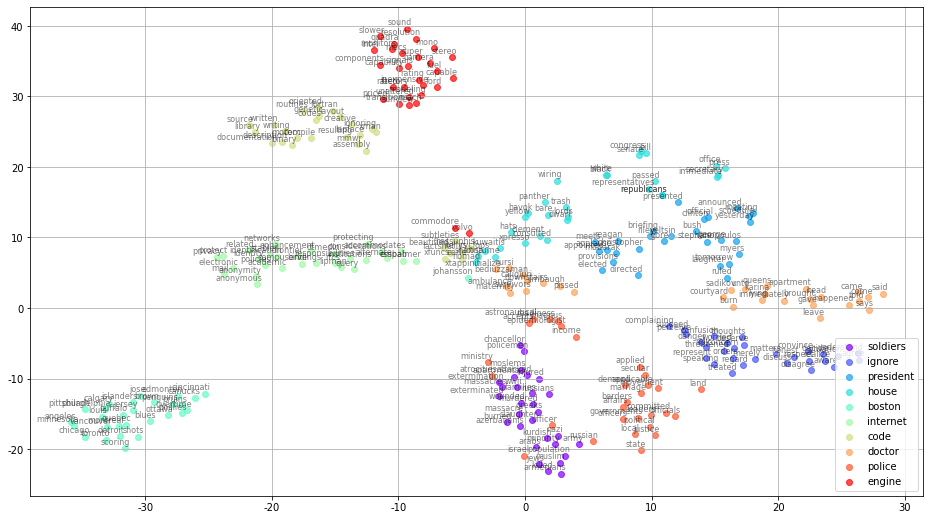

In [ ]:
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import matplotlib as mpl
% matplotlib inline

tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
  plt.figure(figsize=(16, 9))
  colors = cm.rainbow(np.linspace(0, 1, len(labels)))
  for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=color, alpha=a, label=label)
    for i, word in enumerate(words):
      plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), 
      textcoords='offset points', ha='right', va='bottom', size=8)
  mpl.rcParams['axes.unicode_minus'] = False 
  # plt.rc('font', family='NanumBarunGothic') 
  plt.legend(loc=4)
  plt.grid(True)
  plt.show()


tsne_plot_similar_words(keys, embeddings_en_2d, word_clusters)

In [ ]:
for word in keys:
    print(word, end = ' : ')
    for similar_word, _ in glove.most_similar(word, number=10):
        print(similar_word, end =' ')
    print('\n\n')

soldiers : greeks attacked murdered slaughter apartments burned wounded killed armenians 


ignore : respect realize complaining honest decide represent worried concern matters 


president : yeltsin bush stephanopoulos clinton mubarak christopher gore george meets 


house : white lords black representatives wiring bill havok panther republicans 


boston : montreal quebec detroit toronto chicago vancouver islanders pittsburgh ottawa 


internet : stable anonymity identification identity electronic privacy policies compuserve dtmedin 


code : source factsnet beautified genetic mmwr nassuphis codes kellys earle 


doctor : told karina queens said sadikov head immediately brought apartment 


police : officers epidemiologist governments borders affairs state movement russian officials 


engine : ford intel inexpensive resolution factory sunview rating quadra sound 


